In [1]:
import os
import json
import pickle
from collections import Counter
import pandas as pd
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [2]:
activity_df = pd.read_csv("../data/training_data_subset.csv", delimiter=";")
activity_df = activity_df.drop(columns=["CompoundID"])
activity_df.dropna(subset=["Label"], inplace=True)
activity_df.head()

,Label,Hf_Hf_d1,Hf_Hf_d2,Hf_Hf_d3,Hf_Hf_d4,Hf_Hf_d5,Hf_Hf_d6,Hf_Hf_d7,Hf_Hf_d8,Hf_Hf_d9,...,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3
0,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,1,0,0,1,0,0,0.272727
1,active,0.0,0.0,0.3,1.3,0.3,0.0,0.0,0.0,0.0,...,1,2,2,0,0,0,1,2,2,0.600000
2,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,0,0,2,0,0,0.250000
3,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,1,1,0,1,1,0,0,0.285714
4,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,0,0,0,2,0,0,0.333333


In [3]:
X = activity_df[activity_df.columns.difference(["Label"])]
y = activity_df["Label"]

In [4]:
X.shape, y.shape

((4258, 343), (4258,))

# Encoding labels to integers

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

# Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, label_encoded_y, test_size=0.2, random_state=42
)

# Train XGB model - Pre SMOTE

In [7]:
default_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=800,
    eval_metric="aucpr",
    random_state=42,
)

default_model.fit(
    X_train,
    y_train,
    verbose=True,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [8]:
scores = cross_val_score(default_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.98


In [9]:
y_pred = default_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.98      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.79      0.59      0.64       852
weighted avg       0.98      0.98      0.98       852



# Train XGB model - Post SMOTE

In [10]:
sm = SMOTE(random_state=42)
X_smote_train, y_smote_train = sm.fit_resample(X_train, y_train)
print("Resampled dataset shape %s" % Counter(y_smote_train))

Resampled dataset shape Counter({1: 3364, 0: 3364})


In [11]:
smote_default_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=800,
    eval_metric="aucpr",
    random_state=42,
)

smote_default_model.fit(
    X_smote_train,
    y_smote_train,
    verbose=True,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [12]:
smote_scores = cross_val_score(default_model, X_smote_train, y_smote_train, cv=10)
print("Mean cross-validation score: %.2f" % smote_scores.mean())

Mean cross-validation score: 0.99


In [13]:
y_smote_pred = smote_default_model.predict(X_test)
print(classification_report(y_test, y_smote_pred))

              precision    recall  f1-score   support

           0       0.62      0.31      0.42        16
           1       0.99      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.81      0.65      0.70       852
weighted avg       0.98      0.98      0.98       852



# Hyperparameter optimization

In [14]:
# Hyperparameter tuning
param_grid = {
    "n_estimators": [700],
    "learning_rate": [0.025, 0.05],
    "max_depth": [8, 10],
    "gamma": [0, 1],
    "colsample_bytree": [0.5],
    "min_child_weight": [2, 3, 5],
    "subsample": [1],
}

grid_search = GridSearchCV(
    estimator=smote_default_model,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=0,
)

grid_search.fit(X_smote_train, y_smote_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 700, 'subsample': 1}


In [15]:
# Final model
final_model = xgb.XGBClassifier(
    **grid_search.best_params_, objective="binary:logistic", eval_metric="auc"
)

final_model.fit(X_smote_train, y_smote_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
# Evaluate
y_pred_test_final = final_model.predict(X_test)

print("Train set performance:")
print(classification_report(y_test, y_pred_test_final))

Train set performance:
              precision    recall  f1-score   support

           0       0.62      0.31      0.42        16
           1       0.99      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.81      0.65      0.70       852
weighted avg       0.98      0.98      0.98       852



# Saving the final model

In [17]:
os.makedirs("../models", exist_ok=True)

In [18]:
with open("../models/final_model_PLD_XGBoost.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("../models/final_model_PLD_XGBoost_params.json", "a") as f:
    json.dump(grid_search.best_params_, f)

# Confusion matrix

In [19]:
os.makedirs("../figures", exist_ok=True)

In [20]:
cm = confusion_matrix(y_test, y_pred_test_final)

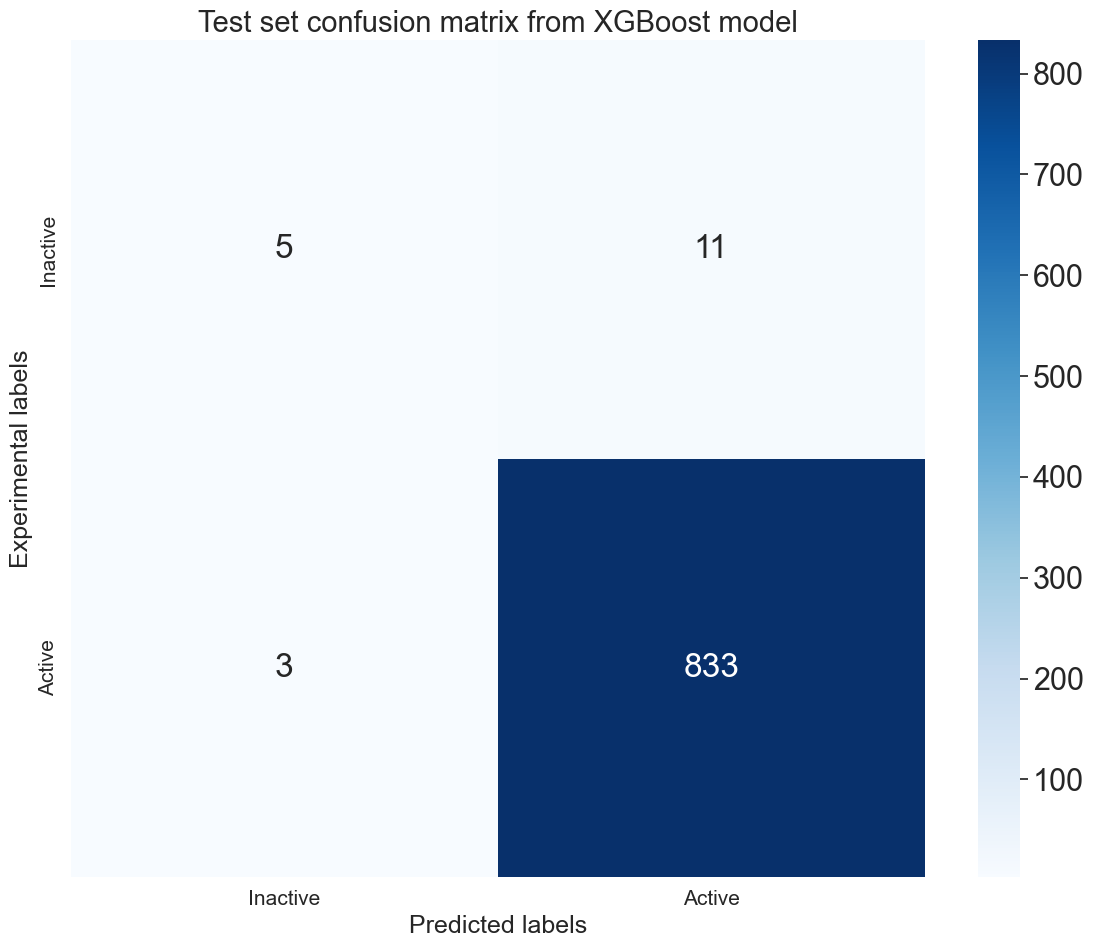

In [21]:
plt.figure(figsize=(12, 10))
sns.set_theme(font_scale=2.0)  # Adjust to fit
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")

# Labels, title and ticks
label_font = {"size": "18"}  # Adjust to fit
ax.set_xlabel("Predicted labels", fontdict=label_font)
ax.set_ylabel("Experimental labels", fontdict=label_font)

title_font = {"size": "21"}  # Adjust to fit
ax.set_title("Test set confusion matrix from XGBoost model", fontdict=title_font)

ax.tick_params(axis="both", which="major", labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(["Inactive", "Active"], fontsize=15)
ax.yaxis.set_ticklabels(["Inactive", "Active"], fontsize=15)

plt.tight_layout()
plt.savefig("../figures/confusion_matrix_PLD_XGBoost.png", dpi=400)
plt.show()